# Compute Latency

This example demonstrates how to use direct function calls of the low-level TAT-C library to perform latency analysis.

Similar to the _Collect Observations_ and _Compute Coverage_ examples, the first steps are to define the satellites for the mission. This example again uses the NOAA-20 satellite with a two-line elements model from July 2022 and a VIIRS instrument with field of regard computed based on a 834km altitude and 3000km swath width. Points are distributed over the globe with a 5000 km characteristic distance and observations are collected over a 30 day period starting on July 14, 2022 at noon UTC.

In [1]:
from tatc import utils
from tatc.schemas import Instrument, Satellite, TwoLineElements

viirs = Instrument(
    name="VIIRS",
    field_of_regard=utils.swath_width_to_field_of_regard(834000, 3000000),
    req_target_sunlit=True,
)
noaa20 = Satellite(
    name="NOAA 20",
    orbit=TwoLineElements(
        tle=[
            "1 43013U 17073A   22195.78278435  .00000038  00000+0  38919-4 0  9996",
            "2 43013  98.7169 133.9110 0001202  63.8768 296.2532 14.19561306241107",
        ]
    ),
    instruments=[viirs],
)

from tatc.generation import generate_cubed_sphere_points

points_df = generate_cubed_sphere_points(5000e3)

from tatc.schemas import Point

points = points_df.apply(
    lambda r: Point(id=r.point_id, latitude=r.geometry.y, longitude=r.geometry.x),
    axis=1,
)

from datetime import datetime, timedelta, timezone

start = datetime(year=2022, month=7, day=14, hour=12, tzinfo=timezone.utc)
end = start + timedelta(days=30)

from tatc.analysis import collect_observations
from joblib import Parallel, delayed
import pandas as pd

observations_list = Parallel(n_jobs=-1)(
    delayed(collect_observations)(point, noaa20, viirs, start, end) for point in points
)
observations = pd.concat(observations_list, ignore_index=True)
display(observations)

,point_id,geometry,satellite,instrument,start,end,epoch,sat_alt,sat_az
0,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,2022-07-26 23:05:45.077898+00:00,2022-07-26 23:08:44.793198+00:00,2022-07-26 23:07:14.935548+00:00,23.232377,96.379436
1,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,2022-07-29 00:07:14.187520+00:00,2022-07-29 00:14:00.195900+00:00,2022-07-29 00:10:37.191710+00:00,44.281070,81.971065
2,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,2022-07-29 23:48:34.454547+00:00,2022-07-29 23:54:41.391443+00:00,2022-07-29 23:51:37.922995+00:00,36.376878,86.223988
3,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,2022-07-30 23:30:01.123712+00:00,2022-07-30 23:35:11.392518+00:00,2022-07-30 23:32:36.258115+00:00,29.980472,90.546671
4,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,2022-07-31 23:11:40.871422+00:00,2022-07-31 23:15:23.426119+00:00,2022-07-31 23:13:32.148770500+00:00,24.749754,94.926526
...,...,...,...,...,...,...,...,...,...
2327,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,2022-08-12 18:28:49.325939+00:00,2022-08-12 18:34:03.183661+00:00,2022-08-12 18:31:26.254800+00:00,31.260724,324.671047
2328,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,2022-08-12 21:48:42.817756+00:00,2022-08-12 21:49:48.545180+00:00,2022-08-12 21:49:15.681468+00:00,21.116313,13.096062
2329,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,2022-08-12 23:25:35.417650+00:00,2022-08-12 23:31:03.448822+00:00,2022-08-12 23:28:19.433236+00:00,32.782539,37.025943
2330,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,2022-08-13 01:04:19.959524+00:00,2022-08-13 01:11:46.499770+00:00,2022-08-13 01:08:03.229647+00:00,73.846900,59.291643


Latency analysis measures the interval between observations and downlink to the first ground station. The following specifies a ground station at Hoboken with a 10-degree minimum elevaiton angle for downlink.

In [2]:
from tatc.schemas import GroundStation

hoboken = GroundStation(
    name="Hoboken", latitude=40.74259, longitude=-74.02686, min_elevation_angle=10
)

from tatc.analysis import collect_downlinks

downlinks = collect_downlinks(hoboken, noaa20, start, end)
display(downlinks)

,station,geometry,satellite,start,end,epoch
0,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-07-14 17:12:43.783775+00:00,2022-07-14 17:22:57.443532+00:00,2022-07-14 17:17:50.613653500+00:00
1,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-07-14 18:54:04.803778+00:00,2022-07-14 19:02:24.959866+00:00,2022-07-14 18:58:14.881822+00:00
2,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-07-15 05:32:06.586963+00:00,2022-07-15 05:39:35.876056+00:00,2022-07-15 05:35:51.231509500+00:00
3,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-07-15 07:11:08.228603+00:00,2022-07-15 07:21:37.144444+00:00,2022-07-15 07:16:22.686523500+00:00
4,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-07-15 16:54:27.859081+00:00,2022-07-15 17:03:52.171691+00:00,2022-07-15 16:59:10.015386+00:00
...,...,...,...,...,...,...
123,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-08-12 08:28:06.699388+00:00,2022-08-12 08:32:42.220364+00:00,2022-08-12 08:30:24.459876+00:00
124,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-08-12 16:30:10.560649+00:00,2022-08-12 16:37:44.339077+00:00,2022-08-12 16:33:57.449863+00:00
125,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-08-12 18:08:25.811875+00:00,2022-08-12 18:19:01.154517+00:00,2022-08-12 18:13:43.483196+00:00
126,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-08-13 06:26:49.183843+00:00,2022-08-13 06:37:29.401372+00:00,2022-08-13 06:32:09.292607500+00:00


Finally, latencies are computed by comparing the observations and downlink opportunities.

In [3]:
from tatc.analysis import compute_latencies

latencies = compute_latencies(observations, downlinks)
display(latencies)

,point_id,geometry,satellite,instrument,sat_alt,sat_az,station,downlinked,latency,observed
0,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,23.232377,96.379436,Hoboken,2022-07-27 05:10:20.165302+00:00,0 days 06:03:05.229754,2022-07-26 23:07:14.935548+00:00
1,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,44.281070,81.971065,Hoboken,2022-07-29 06:13:31.927716500+00:00,0 days 06:02:54.736006500,2022-07-29 00:10:37.191710+00:00
2,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,36.376878,86.223988,Hoboken,2022-07-30 05:54:36.620577+00:00,0 days 06:02:58.697582,2022-07-29 23:51:37.922995+00:00
3,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,29.980472,90.546671,Hoboken,2022-07-31 05:35:38.300419+00:00,0 days 06:03:02.042304,2022-07-30 23:32:36.258115+00:00
4,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,24.749754,94.926526,Hoboken,2022-08-01 05:16:36.756741500+00:00,0 days 06:03:04.607971,2022-07-31 23:13:32.148770500+00:00
...,...,...,...,...,...,...,...,...,...,...
2327,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,31.260724,324.671047,Hoboken,2022-08-13 06:32:09.292607500+00:00,0 days 12:00:43.037807500,2022-08-12 18:31:26.254800+00:00
2328,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,21.116313,13.096062,Hoboken,2022-08-13 06:32:09.292607500+00:00,0 days 08:42:53.611139500,2022-08-12 21:49:15.681468+00:00
2329,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,32.782539,37.025943,Hoboken,2022-08-13 06:32:09.292607500+00:00,0 days 07:03:49.859371500,2022-08-12 23:28:19.433236+00:00
2330,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,73.846900,59.291643,Hoboken,2022-08-13 06:32:09.292607500+00:00,0 days 05:24:06.062960500,2022-08-13 01:08:03.229647+00:00


Similar to _Coverage Analysis_, latency analysis can also be reduced to compute descriptive statistics for each observation point.

In [4]:
from tatc.analysis import reduce_latencies

reduced_results = reduce_latencies(latencies)
display(reduced_results)

,point_id,geometry,latency,samples
0,0,POINT Z (-157.51699 -67.51699 0.00000),0 days 05:35:49.050223,26
1,1,POINT Z (-112.55097 -67.51699 0.00000),0 days 08:39:17.227225,26
2,2,POINT Z (-67.58495 -67.51699 0.00000),0 days 02:12:20.214986,24
3,3,POINT Z (-22.61894 -67.51699 0.00000),0 days 01:39:30.747775,24
4,4,POINT Z (22.34708 -67.51699 0.00000),0 days 04:47:31.405997,25
5,5,POINT Z (67.31310 -67.51699 0.00000),0 days 07:39:49.673805,25
6,6,POINT Z (112.27912 -67.51699 0.00000),0 days 01:16:16.234832,26
7,7,POINT Z (157.24514 -67.51699 0.00000),0 days 02:47:34.997641,27
8,8,POINT Z (-157.51699 -22.55097 0.00000),0 days 05:44:51.280914,36
9,9,POINT Z (-112.55097 -22.55097 0.00000),0 days 08:39:44.055032,36


Finally, GeoPlot can visualize the geospatial data.

(-90.0, 90.0)

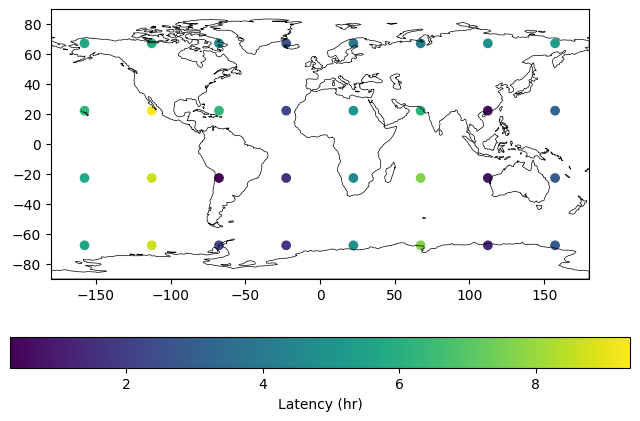

In [5]:
import matplotlib.pyplot as plt
import geopandas as gpd

# load a shapefile containing land from https://www.naturalearthdata.com/downloads/110m-physical-vectors/
worldmap = gpd.read_file("ne_110m_land.zip")

reduced_results["latency_hr"] = reduced_results.latency / timedelta(hours=1)

fig, ax = plt.subplots(figsize=(8, 5))
reduced_results.plot(
    column="latency_hr",
    legend=True,
    legend_kwds={"label": "Latency (hr)", "orientation": "horizontal"},
    ax=ax,
)
worldmap.boundary.plot(ax=ax, color="black", lw=0.5)
plt.xlim([-180, 180])
plt.ylim((-90, 90))

Similar to _Coverage Analysis_, cells can also be used to aggregate descriptive statistics.  Note that, when working on the reduced results, the revisit aggregation function must perform a weighted average based on the number of samples for each point.

In [6]:
from tatc.generation.cells import generate_cubed_sphere_cells

cells_df = generate_cubed_sphere_cells(5000e3)

import numpy as np

grid_results = (
    cells_df.sjoin(reduced_results, how="inner", predicate="contains")
    .dissolve(
        by="cell_id",
        aggfunc={
            "samples": "sum",
            "latency_hr": lambda r: np.average(
                r, weights=reduced_results.loc[r.index, "samples"]
            ),
        },
    )
    .reset_index()
)
display(grid_results)

,cell_id,geometry,samples,latency_hr
0,0,"POLYGON Z ((-135.03398 -90.00000 0.00000, -135...",26,5.596958
1,1,"POLYGON Z ((-90.06796 -90.00000 0.00000, -90.0...",26,8.654785
2,2,"POLYGON Z ((-45.10194 -90.00000 0.00000, -45.1...",24,2.205615
3,3,"POLYGON Z ((-0.13593 -90.00000 0.00000, -0.135...",24,1.658541
4,4,"POLYGON Z ((44.83009 -90.00000 0.00000, 44.830...",25,4.792057
5,5,"POLYGON Z ((89.79611 -90.00000 0.00000, 89.796...",25,7.663798
6,6,"POLYGON Z ((134.76213 -90.00000 0.00000, 134.7...",26,1.271176
7,7,"POLYGON Z ((179.72815 -90.00000 0.00000, 179.7...",27,2.793055
8,8,"POLYGON Z ((-135.03398 -45.03398 0.00000, -135...",36,5.747578
9,9,"POLYGON Z ((-90.06796 -45.03398 0.00000, -90.0...",36,8.662238


Finally, GeoPlot can illustrate the latency over global regions.

(-90.0, 90.0)

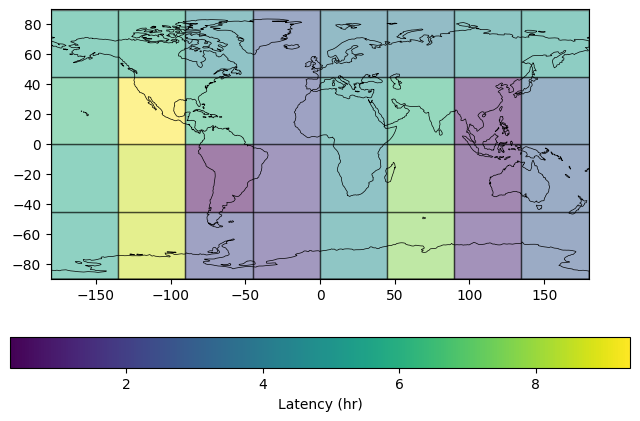

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
grid_results.plot(
    column="latency_hr",
    cmap="viridis",
    edgecolor="k",
    alpha=0.5,
    legend=True,
    legend_kwds={"label": "Latency (hr)", "orientation": "horizontal"},
    ax=ax,
)
worldmap.boundary.plot(ax=ax, color="black", lw=0.5)
plt.xlim([-180, 180])
plt.ylim((-90, 90))